In [1]:
%load_ext autoreload

In [214]:
%autoreload
import copy
import sys
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from einops import rearrange
from functorch import vmap
from torch.utils.data import DataLoader, random_split
from tqdm.auto import tqdm

sys.path.append("/scratch/gpfs/js5013/programs/cfilt/")
from cfilt.utils import *

In [84]:
def remove_data_parallel(old_state_dict):
    new_state_dict = OrderedDict()

    for k, v in old_state_dict.items():
        name = k[7:]  # remove `module.`
        new_state_dict[name] = v

    return new_state_dict

In [99]:
class Cascade(nn.Module):
    def __init__(self, base_model, load_paths):
        super().__init__()
        self.models = [copy.deepcopy(base_model) for _ in range(len(load_paths))]
        for i, m in tqdm(enumerate(self.models), total=len(load_paths)):
            state_dict = torch.load(load_paths[i])
            state_dict = remove_data_parallel(state_dict)
            m.load_state_dict(state_dict)
        self.models = nn.ModuleList(self.models)
        self.intermediates = []

    def get_intermediates(self):
        return self.intermediates

    def forward(self, x):
        self.intermediates.clear()
        for m in self.models:
            x = m(x)
            self.intermediates.append(x)
        return x

In [125]:
ds = CDS(
    [1, 4, 8, 16, 32, 80, 160, 320, 1600],
    "jx",
    "../out/",
    normalize=True,
    transform=transforms.ToTensor(),
)

  0%|          | 0/9 [00:00<?, ?it/s]

In [202]:
train_len = int(len(ds) * 0.95)
train_ds, test_ds = random_split(ds, (train_len, len(ds) - train_len))

dl_cfg = dict(
    batch_size=4,
    shuffle=True,
    collate_fn=unpack,
    num_workers=16,
    pin_memory=True,
)
train_dl = DataLoader(train_ds, **dl_cfg)
test_dl = DataLoader(test_ds, **dl_cfg)

In [174]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [175]:
ac = nn.Sequential(
    ConvXCoder((125, 133), 1, 4, 4, 3, device),
    ConvXCoder((125, 133), 4, 1, 4, 3, device),
)

In [176]:
csc = Cascade(
    ac,
    [
        f"../models/convxcoder/{low}-{high}-3l-4c-new.pt"
        for low, high in zip(
            [1, 4, 8, 16, 32, 80, 160, 320], [4, 8, 16, 32, 80, 160, 320, 1600]
        )
    ],
).to(device)

  0%|          | 0/8 [00:00<?, ?it/s]

In [179]:
optimizer = torch.optim.Adam(csc.parameters(), lr=1e-3)
loss_fn = MS_SSIM_L1_Loss(alpha=0.7)
maploss = vmap(loss_fn, in_dims=0)

In [224]:
denormalize = lambda x, mean, std: x * std + mean
mapdenorm = vmap(denormalize, in_dims=0)

In [229]:
im = csc.get_intermediates()
torch.stack(im).shape

torch.Size([8, 4, 1, 125, 133])

In [ ]:
epochs = 50
means = torch.tensor(list(ds.mean.values()))[1:].reshape(-1, 1, 1, 1, 1).to(device)
stds = torch.tensor(list(ds.std.values()))[1:].reshape(-1, 1, 1, 1, 1).to(device)

losses = []
for e in (pbar := tqdm(range(epochs))):
    csc.train()
    for i, x in enumerate(train_dl):
        optimizer.zero_grad()

        out = csc(x[0].to(device))
        im = csc.get_intermediates()

        im = torch.stack(im) * stds + means
        truths = torch.stack(x[1:]).to(device) * stds + means

        loss = maploss(im, truths).sum()

        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    pbar.set_description(f"loss: {loss.item():.2e}")

  0%|          | 0/50 [00:00<?, ?it/s]

In [206]:
csc.eval()
x = next(iter(test_dl))
out = csc(x[0].to(device))
im = csc.get_intermediates()

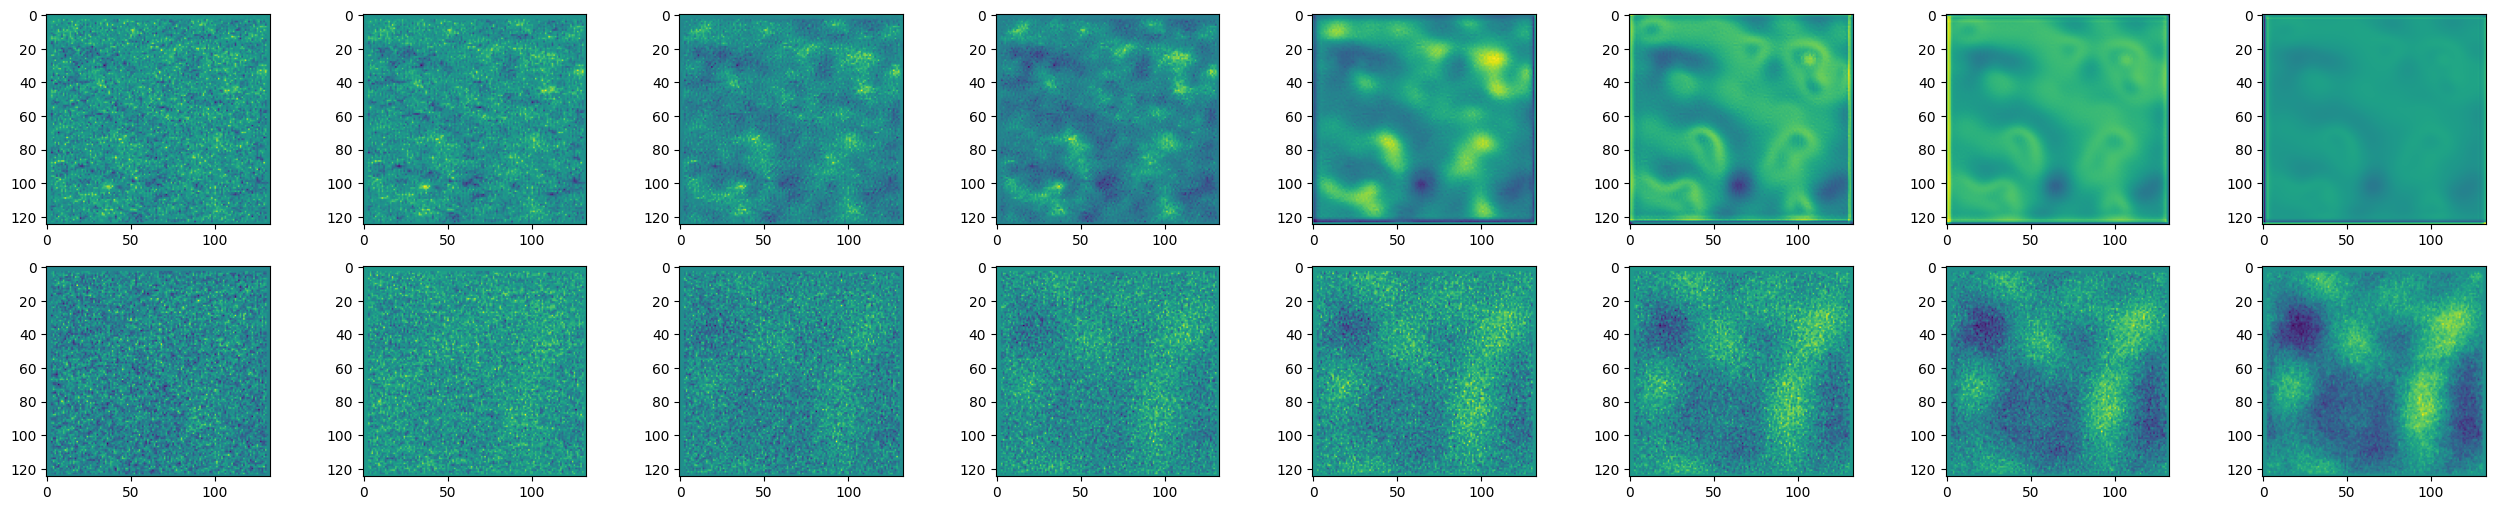

In [207]:
n = len(x) - 1
fig, ax = plt.subplots(2, n, figsize=(4 * n, 6))
for i in range(8):
    ax[0, i].imshow(im[i][0][0].detach().cpu().numpy())
    ax[1, i].imshow(x[i + 1][0][0].detach().cpu().numpy())